### Imports

In [30]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Accessing Paper Titles

Unlabelled data

In [7]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

papers_unlabelled = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    papers_unlabelled.extend(papers)

In [8]:
papers_unlabelled[:3]

['The psychological impact of quarantine and how to reduce it: rapid review of the evidence',
 'Global, regional, and national incidence, prevalence, and years lived with disability for 354 diseases and injuries for 195 countries and territories, 1990–2017: a systematic analysis for the Global Burden of Disease Study 2017',
 'A novel coronavirus outbreak of global health concern']

Labelled data

In [9]:
# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_name = 'Copy of finaldataset'

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

# Open the Google Sheet
sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

# Get list of article names & labels from the sheet
papers_labelled = sheet.col_values(3)[1:]
labels = sheet.col_values(15)[1:]

In [10]:
labels = [int(float(i)) for i in labels]

In [11]:
papers_labelled[:3], labels[:3]

(['COVID-19: the gendered impacts of the outbreak',
  'COVID-19: towards controlling of a pandemic',
  'Prevention and treatment of low back pain: evidence, challenges, and promising directions'],
 [3, 1, 3])

### Preprocessing

In [12]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Define stopwords to remove
stop_words = stopwords.words('english')
stop_words.extend(['covid19', 'sarscov2'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet tags for lemmatisation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    else:
        return None

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Break down into individual words
    words = word_tokenize(title_lower)

    # Remove stopwords
    # words = [word for word in words if word not in stop_words]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Remove words that are nouns (NN, NNS, NNP, NNPS)
    non_noun_words = [word for word, pos in tagged_words if not pos.startswith('N')]

    # Lemmatisation of words & removal of words that aren't adjectives/verbs/adverbs
    lemmatised_words = [lemmatizer.lemmatize(word) for word in non_noun_words]

    return lemmatised_words

# Apply preprocessing to all titles
papers_labelled_processed = [preprocess_title(title) for title in papers_labelled]
papers_unlabelled_processed = [preprocess_title(title) for title in papers_unlabelled]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
papers_labelled_processed[:3]

[['covid19', 'the', 'gendered', 'of', 'the'],
 ['controlling', 'of', 'a', 'pandemic'],
 ['and', 'of', 'low', 'back', 'and', 'promising']]

In [14]:
papers_unlabelled_processed[:3]

[['the',
  'psychological',
  'of',
  'and',
  'how',
  'to',
  'reduce',
  'it',
  'rapid',
  'of',
  'the'],
 ['global',
  'regional',
  'and',
  'national',
  'and',
  'lived',
  'with',
  'for',
  '354',
  'and',
  'for',
  '195',
  'and',
  '19902017',
  'a',
  'systematic',
  'for',
  'the',
  'global',
  'of',
  '2017'],
 ['a', 'novel', 'of', 'global']]

### Bag of Words Representation

In [15]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer on preprocessed titles and transform them into a BoW representation
labelled_bow = vectorizer.fit_transform([" ".join(title) for title in papers_labelled_processed])

# Store the vocabulary used for creating BoW representations
vocabulary = vectorizer.get_feature_names_out()

In [16]:
labelled_bow

<100x288 sparse matrix of type '<class 'numpy.int64'>'
	with 623 stored elements in Compressed Sparse Row format>

In [17]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(vocabulary=vocabulary)

# Fit the vectorizer on preprocessed titles and transform them into a BoW representation
unlabelled_bow = vectorizer.fit_transform([" ".join(title) for title in papers_unlabelled_processed])

In [18]:
unlabelled_bow

<1242x288 sparse matrix of type '<class 'numpy.int64'>'
	with 5290 stored elements in Compressed Sparse Row format>

In [19]:
# Split the dataset into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(labelled_bow, labels, test_size=0.2, random_state=42)

# Define a range of hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 1, 2, 3, 5, 8, 10, 20, 30]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted')

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
best_rf_model = grid_search.best_estimator_

# Make predictions on the validation set using the best model
y_pred = best_rf_model.predict(X_val)

# Calculate metrics
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Validation weighted F1: {f1}")

# Predict labels for unlabelled data using the best model
predicted_scores = best_rf_model.predict(unlabelled_bow)

Best hyperparameters: {'max_depth': 30, 'n_estimators': 100}
Validation weighted F1: 0.55


### Model Comparison

In [23]:
# Define the range of hyperparameters for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', None]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9]
}

param_grid_dt = {
    'max_depth': [None, 1, 2, 3, 5, 8, 10, 20, 30]
}

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}

param_grid_nn = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'alpha': [0.0001, 0.0005, 0.001]
}

# Initialize models
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'Logistic Regression': (LogisticRegression(random_state=42), param_grid_lr),
    'SVM': (SVC(random_state=42), param_grid_svm),
    'K-Nearest Neighbors': (KNeighborsClassifier(), param_grid_knn),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), param_grid_dt),
    'Multinomial Naive Bayes': (MultinomialNB(), param_grid_nb),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb),
    'Neural Network': (MLPClassifier(random_state=42, max_iter=1000), param_grid_nn)
}

best_models = {}

for model_name, (model, param_grid) in models.items():
    # Perform grid search with 5-fold cross-validation using F1 score as the scoring metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')

    # Fit the model to find the best hyperparameters
    grid_search.fit(labelled_bow, labels)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Calculate F1 score using cross-validation
    cv_scores = cross_val_score(best_model, labelled_bow, labels, cv=5, scoring='f1_weighted')
    print(f"{model_name} - Cross-Validation F1 score: {np.mean(cv_scores)}")

# Select the best model based on the mean cross-validation F1 score
best_model_name = max(best_models, key=lambda x: np.mean(cross_val_score(best_models[x], labelled_bow, labels, cv=5, scoring='f1_weighted')))
best_model = best_models[best_model_name]

print(f"The best model is: {best_model_name}")


Random Forest - Cross-Validation F1 score: 0.49504151404151403


c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_rati

Logistic Regression - Cross-Validation F1 score: 0.43289197936566365
SVM - Cross-Validation F1 score: 0.46521109523431503
K-Nearest Neighbors - Cross-Validation F1 score: 0.34913793396146336
Decision Tree - Cross-Validation F1 score: 0.49979986027044854
Multinomial Naive Bayes - Cross-Validation F1 score: 0.40360420037478867
Gradient Boosting - Cross-Validation F1 score: 0.49798888583933687
Neural Network - Cross-Validation F1 score: 0.34376201249730665
The best model is: Decision Tree


### Visualising results

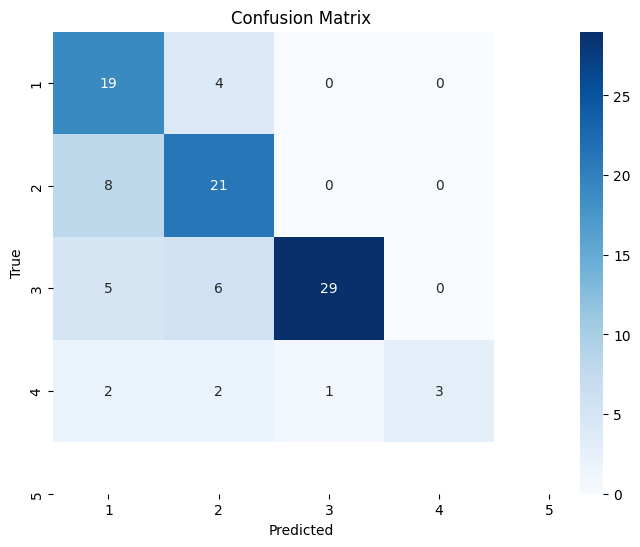

In [34]:
# Fit the best model to the entire training dataset
best_model.fit(labelled_bow, labels)

# Make predictions on the entire dataset
y_pred = best_model.predict(labelled_bow)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, y_pred)

# Define class names
class_names = [1, 2, 3, 4, 5]

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Calculate accuracy
accuracy = accuracy_score(labels, y_pred)

# Calculate F1 score (micro, weighted, or other averaging methods)
f1_micro = f1_score(labels, y_pred, average='micro')
f1_weighted = f1_score(labels, y_pred, average='weighted')

# Calculate precision (micro, weighted, or other averaging methods)
precision_micro = precision_score(labels, y_pred, average='micro')
precision_weighted = precision_score(labels, y_pred, average='weighted')

# Calculate recall (micro, weighted, or other averaging methods)
recall_micro = recall_score(labels, y_pred, average='micro')
recall_weighted = recall_score(labels, y_pred, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Weighted): {f1_weighted}")
print(f"Precision (Micro): {precision_micro}")
print(f"Precision (Weighted): {precision_weighted}")
print(f"Recall (Micro): {recall_micro}")
print(f"Recall (Weighted): {recall_weighted}")


Accuracy: 0.72
F1 Score (Micro): 0.72
F1 Score (Weighted): 0.7248498813014942
Precision (Micro): 0.72
Precision (Weighted): 0.779741532976827
Recall (Micro): 0.72
Recall (Weighted): 0.72


### Put predictions back into spreadsheet

In [21]:
# Predict labels for unlabelled data using the best model
predicted_scores = best_model.predict(unlabelled_bow)

In [22]:
papers_unlabelled[:3], predicted_scores[:3]

(['The psychological impact of quarantine and how to reduce it: rapid review of the evidence',
  'Global, regional, and national incidence, prevalence, and years lived with disability for 354 diseases and injuries for 195 countries and territories, 1990–2017: a systematic analysis for the Global Burden of Disease Study 2017',
  'A novel coronavirus outbreak of global health concern'],
 array([3, 2, 1]))